In [23]:
#!/usr/bin/python3
# import tensorflow as tf
import numpy as np
from math import exp
from numpy.random import binomial
from random import shuffle
from random import seed
import pandas as pd
from IPython.display import display, clear_output
import os
from matplotlib import pyplot as plt
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import CompactLSM

seed(4) # for replicating results

Reservoir Dimension set

In [2]:
nx = 5
ny = 5
nz = 5
N = nx*ny*nz                                          # Reservoir size

N_read = 10                                           # No. of Readout neurons

Important constants related to LIF neuron and synaptic model

In [3]:
global vrest, vth, t_refrac
vrest, vth, t_refrac = 0, 20, 2

tau_m = 32
params_potential = {'C':1, 'g_L':1/tau_m, 'E_L':vrest, 'V_T':vth, 'R_p':t_refrac}

Delay = 1 #constant delay for all synapses in ms

tau_c = 64
C_theta = 10
del_C = 2
n_bits = 4
delta_c = 1
params_conc = {'C_theta':C_theta, 'del_C':del_C, 'tau_c':64, 'nbits':n_bits, 'delta_c':delta_c}

syn_string = "first-order"

sampling_freq = 12.5 # in khz
h = 1/sampling_freq # in ms

time_params = {'h':h, 'Delay':Delay}

Set Reservoir Connections

In [4]:
# Storing the IDs of the neurons
LSM_ID = np.zeros((nx,ny,nz),dtype=np.int64)
l = 0
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            LSM_ID[i,j,k] = l
            l = l + 1

# Storing the synapse connections, and creating the initial weight matrix
seed(1)
k_prob = [0.45, 0.3, 0.6, 0.15]
r_sq = 2**2

W_arr = [3, 6, -2, -2]
W_init = 3
Weights_temp = np.zeros((N,N))

N_in = int(N*0.8)
neuron_type = [ int(i<N_in) for i in range(N)]
shuffle(neuron_type) # 1 for excitatory, 0 for inhibitory

synapes = [dict() for i in range(N)]    # an array of dictonaries which store the location of neuron, 
                                        # type of neuron, and the IDs of the neurons it is connected to

for l in range(N):
    loc = CompactLSM.ID_to_ind(nx,ny,nz,l)
    n_type = neuron_type[l]
    cons = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if l != int(LSM_ID[i,j,k]):
                    dist_sq = (loc[0]-i)**2 + (loc[1]-j)**2 + (loc[2]-k)**2
                    k_probl = 0
                    if n_type == 1:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[0]
                        W_init = W_arr[0]
                      else:
                        k_probl = k_prob[1]
                        W_init = W_arr[1]
                    else:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[2]
                        W_init = W_arr[2]
                      else:
                        k_probl = k_prob[3]
                        W_init = W_arr[3]

                    probability = k_probl* exp(-1*dist_sq/r_sq)
#                     print(probability)
                    check = binomial(1,probability)
                    if check == 1:
                        cons.append(int(LSM_ID[i,j,k]))
                        Weights_temp[l,int(LSM_ID[i,j,k])] = W_init    
    synapes[l] = {"Location":loc, "Neuron_type":n_type, "connections":cons}

global Weights
Weights = Weights_temp


Set Readout neuron initial Weights

In [5]:
All_labels = [str(x) for x in range(10)]
# N_read = 10                                           # No. of Readout neurons
W_init_read = 4                                      # Initial weight, equal for all, update with learning
Weights_temp_readOut = W_init_read*np.ones((N_read, N), dtype='float')
# np.random.seed(4)
# Weights_temp_readOut = np.random.randn(N_read,N)
# Weights_temp_readOut = (Weights_temp_readOut - np.mean(Weights_temp_readOut))/np.std(Weights_temp_readOut)


synapes_read = []        # an array of dictonaries which store the label of neuron, 
                                                      # and the IDs of the neurons it is connected to

for l in range(N_read):
    label = All_labels[l]
    synapes_read.append(label)

Weights_readOut = Weights_temp_readOut

In [6]:
# creating file location and label arrays for train and validate

base = 'PreProcessing/trainBSA'
os.listdir(base)

train_Labels = []
file_name_List = []

for human in os.listdir(base):
    base_up = base + '/' + human
    for train_sample in os.listdir(base_up):
        train_Label = train_sample[0:2]
        file_loc = base_up + '/' + train_sample
        file_name_List.append(file_loc)
        train_Labels.append(train_Label)

seedval = 4

seed(seedval)
shuffle(train_Labels)
seed(seedval)
shuffle(file_name_List)

total_size = len(train_Labels)
train_size = int(total_size*0.8)

validate_Labels = train_Labels[train_size:total_size]
validate_file_list = file_name_List[train_size:total_size]

train_Labels = train_Labels[0:train_size]
train_file_list = file_name_List[0:train_size]

### Finding input neurons to reservoir current and then using the spike train to find the current input to the reservoir

In [7]:
# print("Input neurons =",L)
# print("Size of Reservoir =",nx,"X",ny,"X",nz,",Total total neurons =",N)
# print("Total no.of read out neurons =",N_read)

### solving the reservoir

In [ ]:
# Training
EPOCHS = 5 # From paper

Weights_epoch_save = []
prediction_rate = np.zeros((EPOCHS,))
Validation_rate = np.zeros((EPOCHS,))
for epoch in range(EPOCHS):
    print("="*50)
    correct_predictions = 0

    Input_gen_func = CompactLSM.Input_current_gen(train_file_list, syn_string, N, time_params, training=True, train_Labels=train_Labels)
    NUM_INPUTS = len(train_Labels)
    
    for i in range(NUM_INPUTS):
        In_app, L, M, train_Label,input_num = next(Input_gen_func)      # Generates next input   

        [Reservoir_potential, Reservoir_Spikes] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app, 
                                                                          params_potential, Weights, syn_string)
        
        Readout_potential, Readout_Spikes, trained_weights = CompactLSM.readOut_response(N_read,N, Delay, synapes, M,
                                                                                         h, Reservoir_Spikes, 
                                                                                         params_potential,params_conc,
                                                                                         Weights_readOut,syn_string,
                                                                                         training=True,train_ids=[train_Label])
        
        class_out_label, class_out_idx= CompactLSM.classifier(Readout_Spikes,synapes_read)
        Weights_readOut = trained_weights
        
        display_string = "Epoch: {}, Training input: {}, Classified label: {}, Actual label: {}".format(
            epoch + 1, i + 1, class_out_label, train_Label)
        print("\r"+display_string,end="")

    
        if int(class_out_label) == int(train_Label):
            correct_predictions += 1
    
    Weights_epoch_save.append(Weights_readOut)
    prediction_rate[epoch] = correct_predictions/NUM_INPUTS
    
    path = "Weights/"; file = "weights_epoch{}.csv".format(epoch)
    pd.DataFrame(Weights_readOut).to_csv(path + file)
    display_string = "Last Epoch Prediction rate:{}".format(prediction_rate[epoch] * 100)
    print("\n" + display_string)
    print("*"*50)
    # Validation
    Input_gen_func = CompactLSM.Input_current_gen(validate_file_list, syn_string, N, time_params, training=True, train_Labels=validate_Labels)
    NUM_INPUTS = len(validate_Labels)

    correct_predictions = 0

    for i in range(NUM_INPUTS):
        In_app, L, M, validate_Label,input_num = next(Input_gen_func)      # Generates next input   

        [Reservoir_potential, Reservoir_Spikes] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app, 
                                                                            params_potential, Weights, syn_string)

        Readout_potential, Readout_Spikes, trained_weights = CompactLSM.readOut_response(N_read,N, Delay, synapes, M,
                                                                                            h, Reservoir_Spikes, 
                                                                                            params_potential,params_conc,
                                                                                            Weights_readOut,syn_string,
                                                                                            training=False,train_ids=[validate_Label])

        class_out_label, class_out_idx= CompactLSM.classifier(Readout_Spikes,synapes_read)
#         Weights_readOut = trained_weights

        display_string = "Validate input: {}, Classified label: {}, Actual label: {}".format(
            i + 1, class_out_label, validate_Label)
        print("\r"+display_string,end="")


        if int(class_out_label) == int(validate_Label):
            correct_predictions += 1

    Validation_rate[epoch] = correct_predictions/NUM_INPUTS
    display_string = "Last Epoch validation rate:{}".format(Validation_rate[epoch]*100)
    print("\n" + display_string)
    

In [9]:
# if need to exit training load last trained weights
load_idx = 34
Weights_readOut_fromCsv = pd.read_csv("Weights/weights_epoch{}.csv".format(load_idx), sep=",", header=None)
Weights_readOut = Weights_readOut_fromCsv.to_numpy()

In [186]:
### A single run
syn_string = "second-order"
Input_gen_func = CompactLSM.Input_current_gen(validate_file_list, syn_string, N, time_params, training=True, train_Labels=validate_Labels)
i=-1

In [207]:
In_app, L, M, validate_Label,input_num = next(Input_gen_func)      # Generates next input   
[Reservoir_potential, Reservoir_Spikes] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app, 
                                                                            params_potential, Weights, syn_string)

Readout_potential, Readout_Spikes, trained_weights = CompactLSM.readOut_response(N_read,N, Delay, synapes, M,
                                                                                            h, Reservoir_Spikes, 
                                                                                            params_potential,params_conc,
                                                                                            Weights_readOut,syn_string,
                                                                                            training=False,train_ids=[validate_Label])

Weights_readOut = trained_weights

class_out_label, class_out_idx= CompactLSM.classifier(Readout_Spikes,synapes_read)
i = i+1

print('Predicted Label:',class_out_label,'Actual Label:',validate_Label)

data = pd.read_csv(validate_file_list[i], sep=",", header=None)
data_as_numpy = data.to_numpy()
Input_Spikes = data_as_numpy.transpose()   # Single Sample input
# (L,M) = Input_Spikes.shape

Predicted Label: 0 Actual Label: 0


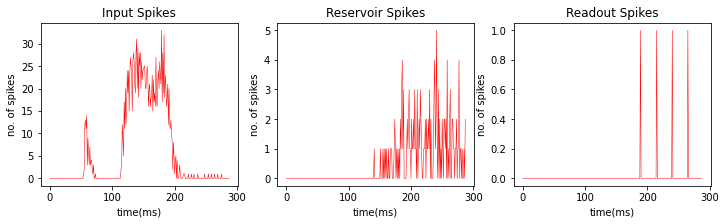

In [208]:
plt.figure(1,figsize=(12,3))

plt.title('Spikes v/s Time')
plt.subplot(1,3,1)
x = np.sum(Input_Spikes,0)
plt.plot(x,'r',linewidth = 0.5)
plt.ylabel('no. of spikes')
plt.xlabel('time(ms)')
plt.title('Input Spikes')

plt.subplot(1,3,2)
x = np.sum(Reservoir_Spikes,0)
plt.plot(x,'r',linewidth = 0.5)
plt.ylabel('no. of spikes')
plt.xlabel('time(ms)')
plt.title('Reservoir Spikes')

plt.subplot(1,3,3)
x = np.sum(Readout_Spikes,0)
plt.plot(x,'r',linewidth = 0.5)
plt.ylabel('no. of spikes')
plt.xlabel('time(ms)')
plt.title('Readout Spikes')

plt.show()

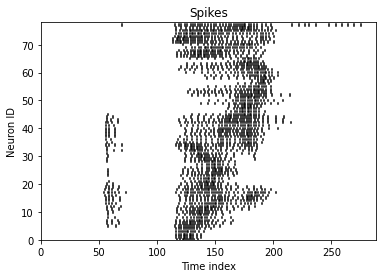

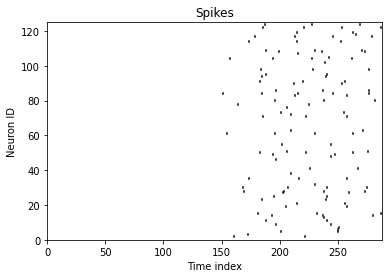

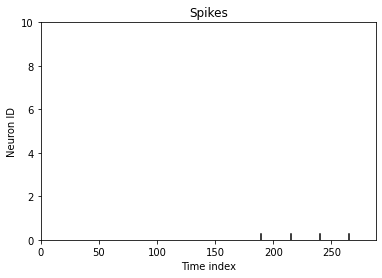

In [209]:
CompactLSM.plot_spikes(Input_Spikes,L,M)
CompactLSM.plot_spikes(Reservoir_Spikes,N,M)
CompactLSM.plot_spikes(Readout_Spikes,N_read,M)